In [1]:
import os
import time
import math
import argparse
import numpy as np
import scipy.io as sio
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import torch
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
import torch.nn.functional as F
from torchsummary import summary
from sklearn.metrics import confusion_matrix


from data_prepare import mirror_hsi
from data_prepare import choose_train_and_test
from data_prepare import choose_all_pixels, all_data
from data_prepare import train_and_test_data, train_and_test_label


from Utils import ActivationOutputData
from Utils import output_metric, plot_confusion_matrix
from CNNUtils import train, test, valid
from Utils import list_to_colormap, classification_map, print_args


%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("A2S2KResNet")
parser.add_argument('--dataset', choices=['LongKou', 'HanChuan', 'HongHu', 'Pavia'], default='Pavia', help='dataset to use')
parser.add_argument('--seed', type=int, default=42, help='number of seed')
parser.add_argument('--batch_size', type=int, default=30, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=15, help='size of patches')
parser.add_argument('--epoches', type=int, default=100, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=1e-3, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight_decay')
parser.add_argument('--train_number', type=int, default=25, help='num_train_per_class')
args = parser.parse_args(args=[])

In [3]:
# prepare data
data_path = os.path.join(os.getcwd(), 'dataset')

if args.dataset == 'LongKou':
    data = sio.loadmat(os.path.join(data_path, 'WHU_Hi_LongKou.mat'))['WHU_Hi_LongKou']
    label = sio.loadmat(os.path.join(data_path, 'WHU_Hi_LongKou_gt.mat'))['WHU_Hi_LongKou_gt']
elif args.dataset == 'HanChuan':
    data = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan.mat'))['WHU_Hi_HanChuan']
    label = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan_gt.mat'))['WHU_Hi_HanChuan_gt']
elif args.dataset == 'Pavia':
    data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
    label = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 9


In [4]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [5]:
def applyPCA(data, numComponents=30):
    new_data = np.reshape(data, (-1, data.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    new_data = pca.fit_transform(new_data)
    new_data = np.reshape(new_data, (data.shape[0], data.shape[1], numComponents))
    return new_data, pca

In [6]:
K = 30
data, pca = applyPCA(data, numComponents=K)

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=610, width=340, band=30


In [7]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

*******************************************************
patch_size : 15
mirror_data shape : [624, 354, 30]
*******************************************************


In [8]:
total_pos_train, total_pos_test, total_pos_valid, number_train, number_test, number_valid = choose_train_and_test(label, args.train_number, args.seed) 

x_train, x_test, x_valid = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, total_pos_valid, args.patch_size)
y_train, y_test, y_valid = train_and_test_label(number_train, number_test, number_valid, num_classes)

*******************************************************
x_train shape = (225, 15, 15, 30), type = float64
x_test  shape = (42551, 15, 15, 30), type = float64
x_valid  shape = (900, 15, 15, 30), type = float64
*******************************************************
y_train: shape = (225,), type = int64
y_test: shape = (42551,), type = int64
y_valid: shape = (900,), type = int64
*******************************************************


In [9]:
total_pos_train[:10]

array([[409, 293],
       [404, 298],
       [380, 301],
       [551,  14],
       [453, 165],
       [140, 172],
       [471, 169],
       [175, 187],
       [482, 185],
       [214, 200]])

In [10]:
# load data
x_train = torch.from_numpy(x_train).unsqueeze(1).type(torch.FloatTensor)  # (90, 1, 7, 7, 176)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
train_label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test).unsqueeze(1).type(torch.FloatTensor)  # (5198, 1, 7, 7, 176)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
test_label = Data.TensorDataset(x_test, y_test)

x_valid = torch.from_numpy(x_valid).unsqueeze(1).type(torch.FloatTensor)  # (5211, 1, 7, 7, 176)
print(x_valid.shape)
y_valid = torch.from_numpy(y_valid).type(torch.LongTensor)
valid_label = Data.TensorDataset(x_valid, y_valid)

train_loader = Data.DataLoader(train_label, batch_size=30, shuffle=True)
test_loader = Data.DataLoader(test_label, batch_size=128, shuffle=True)
valid_loader = Data.DataLoader(valid_label, batch_size=64, shuffle=True)

torch.Size([225, 1, 15, 15, 30])
torch.Size([42551, 1, 15, 15, 30])
torch.Size([900, 1, 15, 15, 30])


## Model

In [11]:
class eca_layer(nn.Module):
    def __init__(self, channel, k_size=3):
        super(eca_layer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.conv = nn.Conv2d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid() 
        
    def forward(self, x):
        # x: input features with shape [b, c, d, h, w]
        b, c, h, w, t = x.size()
        # feature descriptor on the global spatial information
        # 24, 1, 1, 1
        y= self.avg_pool(x)
        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -3)).transpose(-1, -3).unsqueeze(-1)
        # Multi-scale information fusion
        y = self.sigmoid(y)
        return x * y.expand_as(x)
    
    
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, use_1X1conv=False, stride=1, start_block=False, end_block=False):
        super(Residual, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride), nn.ReLU())
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
        if use_1X1conv:
            self.conv3 = nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        if not start_block:
            self.bn0 = nn.BatchNorm3d(in_channels)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.bn2 = nn.BatchNorm3d(out_channels)
        if start_block:
            self.bn2 = nn.BatchNorm3d(out_channels)
        if end_block:
            self.bn2 = nn.BatchNorm3d(out_channels)
        # ECA Attention Layer
        self.ecalayer = eca_layer(out_channels)
        # start and end block initialization
        self.start_block = start_block
        self.end_block = end_block
        
    def forward(self, X):
        identity = X
        if self.start_block:
            out = self.conv1(X)
        else:
            out = self.bn0(X)
            out = F.relu(out)
            out = self.conv1(out)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        if self.start_block:
            out = self.bn2(out)  
        out = self.ecalayer(out)
        out += identity
        if self.end_block:
            out = self.bn2(out)
            out = F.relu(out) 
        return out
    
    
class S3KAIResNet(nn.Module):
    def __init__(self, band, num_classes, reduction=2, PARAM_KERNEL_SIZE=24):
        super(S3KAIResNet, self).__init__()
        self.conv1X1 = nn.Conv3d(in_channels=1, out_channels=PARAM_KERNEL_SIZE, kernel_size=(1, 1, 7), stride=(1, 1, 2), padding=0)
        self.conv3X3 = nn.Conv3d(in_channels=1, out_channels=PARAM_KERNEL_SIZE, kernel_size=(3, 3, 7), stride=(1, 1, 2), padding=(1, 1, 0))
        self.conv5X5 = nn.Conv3d(in_channels=1, out_channels=PARAM_KERNEL_SIZE, kernel_size=(5, 5, 7), stride=(1, 1, 2), padding=(2, 2, 0))
        
        self.batch_norm1X1 = nn.Sequential(nn.BatchNorm3d(PARAM_KERNEL_SIZE, eps=0.001, momentum=0.1, affine=True), nn.ReLU(inplace=True))
        self.batch_norm3X3 = nn.Sequential(nn.BatchNorm3d(PARAM_KERNEL_SIZE, eps=0.001, momentum=0.1, affine=True), nn.ReLU(inplace=True))
        self.batch_norm5X5 = nn.Sequential(nn.BatchNorm3d(PARAM_KERNEL_SIZE, eps=0.001, momentum=0.1, affine=True), nn.ReLU(inplace=True))
        
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.conv_se = nn.Sequential(nn.Conv3d(PARAM_KERNEL_SIZE, band // reduction, 1, padding=0, bias=True), nn.ReLU(inplace=True))
        self.conv_ex = nn.Conv3d(band // reduction, PARAM_KERNEL_SIZE, 1, padding=0, bias=True)
        self.softmax = nn.Softmax(dim=1)
        
        self.res_net1 = Residual(PARAM_KERNEL_SIZE, PARAM_KERNEL_SIZE, (1, 1, 7), (0, 0, 3), start_block=True)
        self.res_net2 = Residual(PARAM_KERNEL_SIZE, PARAM_KERNEL_SIZE, (1, 1, 7), (0, 0, 3))
        self.res_net3 = Residual(PARAM_KERNEL_SIZE, PARAM_KERNEL_SIZE, (3, 3, 1), (1, 1, 0))
        self.res_net4 = Residual(PARAM_KERNEL_SIZE, PARAM_KERNEL_SIZE, (3, 3, 1), (1, 1, 0), end_block=True)
        
        kernel_3d = math.floor((band - 7) / 2 + 1)
        self.conv2 = nn.Conv3d(in_channels=PARAM_KERNEL_SIZE, out_channels=128, padding=(0, 0, 0), kernel_size=(1, 1, kernel_3d), stride=(1, 1, 1))
        self.batch_norm2 = nn.Sequential(nn.BatchNorm3d(128, eps=0.001, momentum=0.1, affine=True), nn.ReLU(inplace=True))
        self.conv3 = nn.Conv3d(in_channels=1, out_channels=PARAM_KERNEL_SIZE, padding=(0, 0, 0), kernel_size=(3, 3, 128), stride=(2, 2, 1))
        self.batch_norm3 = nn.Sequential(nn.BatchNorm3d(PARAM_KERNEL_SIZE, eps=0.001, momentum=0.1, affine=True), nn.ReLU(inplace=True))
        
        self.avg_pooling = nn.AdaptiveAvgPool3d(1)
        self.full_connection = nn.Sequential(nn.Linear(PARAM_KERNEL_SIZE, num_classes))
        
    def forward(self, X):
        x_1x1 = self.conv1X1(X)  # (B, 24, 15, 15, 12)
        x_1x1 = self.batch_norm1X1(x_1x1).unsqueeze(dim=1)
        x_3x3 = self.conv3X3(X)
        x_3x3 = self.batch_norm3X3(x_3x3).unsqueeze(dim=1)
        x_5x5 = self.conv5X5(X)
        x_5x5 = self.batch_norm5X5(x_5x5).unsqueeze(dim=1)
        
        x1 = torch.cat([x_5x5, x_3x3, x_1x1], dim=1)
        U = torch.sum(x1, dim=1)
        S = self.pool(U)
        Z = self.conv_se(S)
        attention_vector = torch.cat([self.conv_ex(Z).unsqueeze(dim=1), self.conv_ex(Z).unsqueeze(dim=1), self.conv_ex(Z).unsqueeze(dim=1)], dim=1)
        attention_vector = self.softmax(attention_vector)
        V = (x1 * attention_vector).sum(dim=1)
        
        x2 = self.res_net1(V)  # (B, 24, 15, 15, 12)
        x2 = self.res_net2(x2)
        x2 = self.batch_norm2(self.conv2(x2))  # (B, 128, 15, 15, 1)
        x2 = x2.permute(0, 4, 2, 3, 1)  # (B, 1, 15, 15, 128)
        x2 = self.batch_norm3(self.conv3(x2))  # (B, 24, 7, 7, 1)
        
        x3 = self.res_net3(x2)
        x3 = self.res_net4(x3)  # (B, 24, 7, 7, 1)
        x4 = self.avg_pooling(x3)
        x4 = x4.view(x4.size(0), -1)
        return self.full_connection(x4)

In [12]:
model = S3KAIResNet(band, num_classes, 2).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)

In [13]:
print('start training')
acc_list = [0.00]
path = './model/A2S2K_RN.pt'
tic = time.time()
for epoch in range(args.epoches):
    # 计算的是移动平均准确率
    train_acc, train_loss = train(model, train_loader, criterion, optimizer)
    valid_acc, valid_loss = valid(model, valid_loader, criterion)
    print("Epoch: {:03d} - train_loss: {:.4f} - train_acc: {:.4f} - valid_loss: {:.4f} - valid_acc: {:.4f}".\
          format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))
    scheduler.step()

    acc_list.append(valid_acc)
    if acc_list[-1] > acc_list[-2]:
        print("val_acc improved from {:.4f} to {:.4f}, saving model to A2S2K_RN.pt".format(acc_list[-2], acc_list[-1]))
        torch.save(model.state_dict(), path)
    else:
        print("val_acc did not improve from {:.4f}".format(acc_list[-2]))
        acc_list[-1] = acc_list[-2]

toc = time.time()
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

start training
Epoch: 001 - train_loss: 1.9045 - train_acc: 33.7778 - valid_loss: 2.1107 - valid_acc: 31.3333
val_acc improved from 0.0000 to 31.3333, saving model to A2S2K_RN.pt
Epoch: 002 - train_loss: 1.5565 - train_acc: 66.2222 - valid_loss: 1.9017 - valid_acc: 39.1111
val_acc improved from 31.3333 to 39.1111, saving model to A2S2K_RN.pt
Epoch: 003 - train_loss: 1.4190 - train_acc: 70.6667 - valid_loss: 1.6391 - valid_acc: 55.3333
val_acc improved from 39.1111 to 55.3333, saving model to A2S2K_RN.pt
Epoch: 004 - train_loss: 1.2908 - train_acc: 77.7778 - valid_loss: 1.4376 - valid_acc: 75.3333
val_acc improved from 55.3333 to 75.3333, saving model to A2S2K_RN.pt
Epoch: 005 - train_loss: 1.1960 - train_acc: 78.6667 - valid_loss: 1.2727 - valid_acc: 77.1111
val_acc improved from 75.3333 to 77.1111, saving model to A2S2K_RN.pt
Epoch: 006 - train_loss: 1.0940 - train_acc: 89.3333 - valid_loss: 1.1715 - valid_acc: 82.3333
val_acc improved from 77.1111 to 82.3333, saving model to A2S2K_RN

In [14]:
model.load_state_dict(torch.load(path))
model.eval()

tar_test, pre_test = test(model, test_loader)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)
AA_test = np.around(AA_test*100, 2)

In [15]:
print("*******************************************************************")
print("Final result:")
print("OA: {:.2f}, AA: {:.2f}, Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print("*******************************************************************")
print("Recal: {}".format(AA_test))
print("*******************************************************************")
print("Parameter:")
print_args(vars(args))
print("*******************************************************************")

*******************************************************************
Final result:
OA: 94.80, AA: 93.50, Kappa: 0.9313
*******************************************************************
Recal: [ 87.54  97.87  89.49  88.12  99.92 100.   100.    92.21  86.33]
*******************************************************************
Parameter:
dataset: Pavia
seed: 42
batch_size: 30
patch_size: 15
epoches: 100
learning_rate: 0.001
gamma: 0.99
weight_decay: 0.001
train_number: 25
*******************************************************************


In [16]:
average_accuracy = str(list(AA_test))
file_name = "./CR/a2s2k_1.txt"

with open(file_name, 'w') as x_file:
    x_file.write("[{:.2f}, {:.2f}, {:.4f}]".format(OA_test * 100., AA_mean_test*100., Kappa_test))
    x_file.write('\n')
    x_file.write('{}'.format(average_accuracy))

## Panoramic Classification

In [17]:
def output_label(model, loader):
    model.eval()
    pre = np.array([]).astype('int')
    with torch.no_grad():
        for batch_idx, (batch_data, batch_target) in enumerate(loader):
            batch_data = batch_data.cuda()
            batch_pred = model(batch_data)  # (B, 9)
            _, pred = batch_pred.topk(1, axis=1)  # (B, 1)
            pp = pred.squeeze()
            pre = np.append(pre, pp.data.cpu().numpy())
    return pre

In [18]:
pos_forward, pos_backward = choose_all_pixels(label)

x_forward, x_backward, y_forward, y_backward = all_data(mirror_data, band, pos_forward, pos_backward, patch_size=args.patch_size)

*******************************************************
x_forward shape = (42776, 15, 15, 30), type = float64
x_backward  shape = (164624, 15, 15, 30), type = float64
*******************************************************


In [19]:
# load data
x_forward = torch.from_numpy(x_forward).unsqueeze(1).type(torch.FloatTensor)
print(x_forward.shape)
y_forward = torch.from_numpy(y_forward).type(torch.LongTensor)  # (13,)
forward_label = Data.TensorDataset(x_forward, y_forward)

x_backward = torch.from_numpy(x_backward).unsqueeze(1).type(torch.FloatTensor)
print(x_backward.shape)
y_backward = torch.from_numpy(y_backward).type(torch.LongTensor)  # (13,)
backward_label = Data.TensorDataset(x_backward, y_backward)

forward_loader = Data.DataLoader(forward_label, batch_size=128, shuffle=False)
backward_loader = Data.DataLoader(backward_label, batch_size=128, shuffle=False)

torch.Size([42776, 1, 15, 15, 30])
torch.Size([164624, 1, 15, 15, 30])


In [20]:
# output classification maps
pre_forward = output_label(model, forward_loader)
pre_backward = output_label(model, backward_loader)

prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(pos_forward.shape[0]):
    prediction_matrix[pos_forward[i, 0], pos_forward[i, 1]] = pre_forward[i] + 1

for j in range(pos_backward.shape[0]):
    prediction_matrix[pos_backward[j, 0], pos_backward[j, 1]] = pre_backward[j] + 1

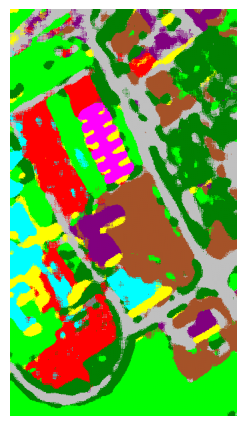

In [21]:
predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))

classification_map(predict_map, './pavia_a2s2k.pdf')

## t-SNE Visualization

In [22]:
def scatter(x, colors, num_classes=9):
    palette = np.array([[192, 192, 192], [0, 255, 1], [0, 255, 255], [0, 128, 1], [255, 0, 254], 
                        [165, 82, 40], [129, 0, 127], [255, 0, 0], [255, 255, 0]])/255.
    
    # We create a scatter plot.
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int_)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(num_classes):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i+1), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
        txts.append(txt)
    fig.savefig('./tsne_a2s2k.pdf', bbox_inches='tight')

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_codings = []
test_tar = []
for batch_idx, (image, label) in enumerate(test_loader):
    with torch.no_grad():
        image = image.to(device)
        label = label.to(device)
        final_features = ActivationOutputData(model.avg_pooling)  # (1, 400, 8)
        _ = model(image)
        final_features.remove()
    test_codings.append(final_features.outputs.squeeze().cpu().data)
    test_tar.append(label.cpu().data)

x_test = torch.concat(test_codings)
y_test = torch.concat(test_tar)

x_test_numpy = x_test.numpy()
y_test_numpy = y_test.numpy()

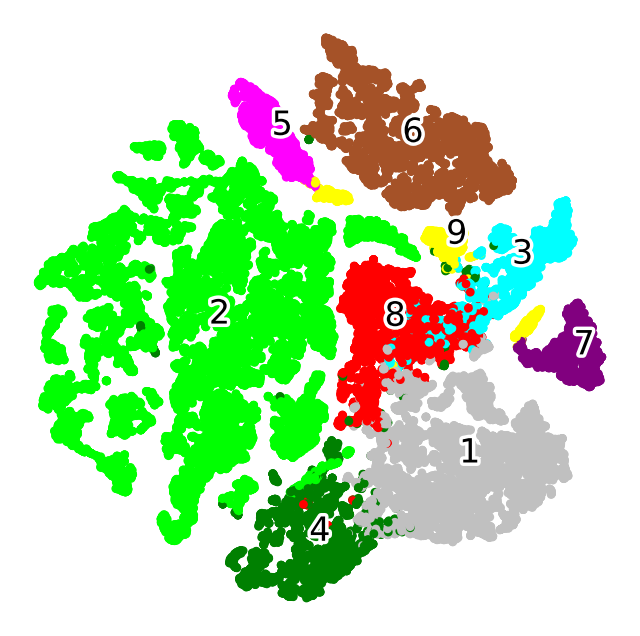

In [24]:
tsne_proj = TSNE(random_state=42).fit_transform(x_test_numpy)

scatter(tsne_proj, y_test_numpy)